<a href="https://colab.research.google.com/github/dev-69/MajorProject/blob/main/BioLinkBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

devsonar_prprpe_path = kagglehub.dataset_download('devsonar/prprpe')

print('Data source import complete.')


In [ ]:
print("Hello BioLinkBert")

Hello BioLinkBert


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
class DischargeNotesDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        if text is None or label is None:
            print(f"Invalid data at index {idx}: {text}, {label}")

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'label': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
class ReadmissionPredictor(nn.Module):
    def __init__(self, bert_model):
        super(ReadmissionPredictor, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use [CLS] token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(y_true, y_pred, labels=['Not Readmitted', 'Readmitted']):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix')
    plt.show()

def train_model(model, train_loader, val_loader, device, num_epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    best_val_accuracy = 0
    model.to(device)  # Move the model to the appropriate device

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        # Training loop with progress bar
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Training)", unit="batch"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validation loop with progress bar
        model.eval()
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Validation)", unit="batch"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                predictions = torch.argmax(outputs, dim=1)

                val_predictions.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        # Print epoch results
        print(f'\nEpoch {epoch + 1}/{num_epochs}:')
        print(f'Average training loss: {total_loss / len(train_loader):.4f}')

        # Calculate and print metrics
        val_accuracy = accuracy_score(val_labels, val_predictions)
        print(f'\nValidation Accuracy: {val_accuracy:.4f}')

        # Print confusion matrix
        print('\nConfusion Matrix:')
        plot_confusion_matrix(val_labels, val_predictions)

        # Print detailed classification report
        print('\nClassification Report:')
        report = classification_report(val_labels, val_predictions, target_names=['Not Readmitted', 'Readmitted'])
        print(report)

        # Explain the metrics
        print('\nMetrics Explanation:')
        print('- Precision: Of the patients we predicted would be readmitted, what percentage actually were')
        print('- Recall: Of the patients who were actually readmitted, what percentage did we identify')
        print('- F1-score: Harmonic mean of precision and recall')
        print('- Support: Number of occurrences of each class in the validation set')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pt')
            print(f'\nSaved new best model with validation accuracy: {val_accuracy:.4f}')


In [ ]:
def predict(text, model, tokenizer, device):
    model.eval()
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        prediction = torch.argmax(outputs, dim=1)

    return prediction.item()

In [ ]:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained("michiyasunaga/BioLinkBERT-large")
    base_model = AutoModel.from_pretrained("michiyasunaga/BioLinkBERT-large")
    model = ReadmissionPredictor(base_model).to(device)

tokenizer_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/447k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

In [ ]:
import pickle
import pandas as pd

df = pd.read_pickle("/kaggle/input/prprpe/Prepared_Data.pkl")
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT,index,CATEGORY,TEXT,OUTPUT_LABEL
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN,NaN,48470.0,Discharge summary,Admission Date: [**2101-10-20**] Discharg...,0
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN,NaN,4782.0,Discharge summary,Admission Date: [**2191-3-16**] Discharge...,0
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaN,NaN,24476.0,Discharge summary,Admission Date: [**2175-5-30**] Dischar...,0
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,NaT,NaN,NaN,57341.0,Discharge summary,"Name: [**Known lastname 10050**], [**Known fi...",0
9,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,NaT,NaN,NaN,34829.0,Discharge summary,Admission Date: [**2178-4-16**] ...,0


In [ ]:
df.TEXT = df.TEXT.fillna(' ')
df.TEXT = df.TEXT.str.replace('\n',' ')
df.TEXT = df.TEXT.str.replace('\r',' ')
df.TEXT = df.TEXT.str.lower()
df.TEXT = df.TEXT.str.replace(r'[^a-zA-Z\s]', '', regex=True)
df.TEXT = df.TEXT.str.replace(r'\s+', ' ', regex=True)
df.TEXT = df.TEXT.str.strip()

In [ ]:
df_filtered = df[['SUBJECT_ID', 'HADM_ID', 'TEXT', 'OUTPUT_LABEL']]
X = df_filtered['TEXT']
y = df_filtered['OUTPUT_LABEL']

df_filtered['OUTPUT_LABEL'].value_counts()

OUTPUT_LABEL
0    48109
1     3004
Name: count, dtype: int64

In [ ]:
X = df_filtered['TEXT'].reset_index(drop=True)
y = df_filtered['OUTPUT_LABEL'].reset_index(drop=True)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_filtered['TEXT'], df_filtered['OUTPUT_LABEL'], test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.tolist()
X_val = X_val.tolist()
y_train = y_train.tolist()
y_val = y_val.tolist()

In [ ]:
print("\nDataset sizes:")
print(f"Training texts: {len(X_train)}")
print(f"Training labels: {len(y_train)}")
print(f"Validation texts: {len(X_val)}")
print(f"Validation labels: {len(y_val)}")


Dataset sizes:
Training texts: 40890
Training labels: 40890
Validation texts: 10223
Validation labels: 10223


In [ ]:
    train_dataset = DischargeNotesDataset(X_train, y_train, tokenizer)
    val_dataset = DischargeNotesDataset(X_val, y_val, tokenizer)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

Epoch 1/1 (Validation): 100%|██████████| 1278/1278 [10:02<00:00,  2.12batch/s]



Epoch 1/1:
Average training loss: 0.2292

Validation Accuracy: 0.9425

Confusion Matrix:


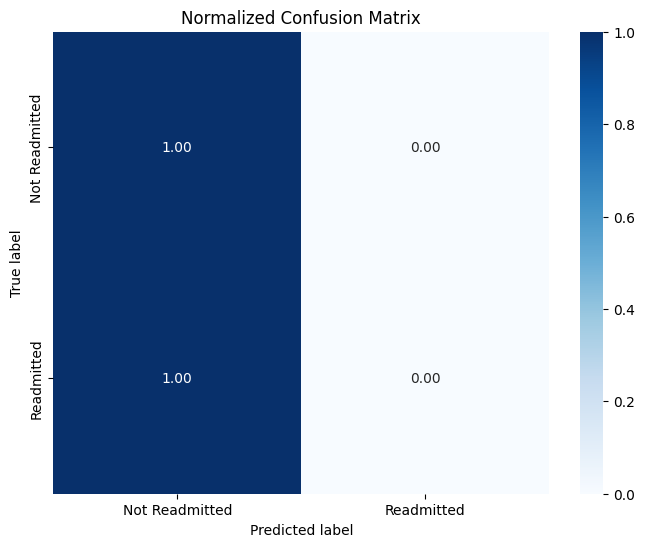


Classification Report:
                precision    recall  f1-score   support

Not Readmitted       0.94      1.00      0.97      9635
    Readmitted       0.00      0.00      0.00       588

      accuracy                           0.94     10223
     macro avg       0.47      0.50      0.49     10223
  weighted avg       0.89      0.94      0.91     10223


Metrics Explanation:
- Precision: Of the patients we predicted would be readmitted, what percentage actually were
- Recall: Of the patients who were actually readmitted, what percentage did we identify
- F1-score: Harmonic mean of precision and recall
- Support: Number of occurrences of each class in the validation set


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Saved new best model with validation accuracy: 0.9425


In [ ]:
train_model(model, train_loader, val_loader, device)

In [ ]:
type(model)

__main__.ReadmissionPredictor

In [ ]:
def save_model_info(model, save_dir='saved_model_info'):
   """
   Saves model, tokenizer, and configuration in a directory
   Args:
       model: The trained model
       save_dir: Directory to save all model information
   """
   import os
   import json
   import torch
   from datetime import datetime

   # Create directory if it doesn't exist
   if not os.path.exists(save_dir):
       os.makedirs(save_dir)

   # Generate timestamp for this save
   timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

   # Save the model state dict
   torch.save(model.state_dict(), f'{save_dir}/model_{timestamp}.pt')

   # Save the model configuration
   config = {
       'model_name': "michiyasunaga/BioLinkBERT-large",
       'max_length': 512,
       'num_classes': 2,
       'hidden_dropout_prob': 0.1,
       'save_timestamp': timestamp,
   }

   # Save class mapping
   class_mapping = {
       0: "Not Readmitted",
       1: "Readmitted"
   }

   # Combine all info
   model_info = {
       'config': config,
       'class_mapping': class_mapping,
       'model_path': f'model_{timestamp}.pt'
   }

   # Save to JSON
   with open(f'{save_dir}/model_info_{timestamp}.json', 'w') as f:
       json.dump(model_info, f, indent=4)

   print(f"Model saved successfully in {save_dir}")
   print(f"Model file: model_{timestamp}.pt")
   print(f"Info file: model_info_{timestamp}.json")

   return timestamp

def load_saved_model(timestamp, save_dir='saved_model_info'):
   """
   Loads a saved model and its configuration
   Args:
       timestamp: Timestamp of the saved model
       save_dir: Directory where model is saved
   Returns:
       model: Loaded model
   """
   import json
   import torch
   from transformers import AutoModel

   # Load model info
   with open(f'{save_dir}/model_info_{timestamp}.json', 'r') as f:
       model_info = json.load(f)

   # Initialize base model and classifier
   base_model = AutoModel.from_pretrained(model_info['config']['model_name'])
   model = ReadmissionPredictor(base_model)

   # Load the saved state dict
   model.load_state_dict(torch.load(f'{save_dir}/model_{timestamp}.pt'))

   print("Model loaded successfully")
   print(f"Model configuration: {model_info['config']}")
   print(f"Class mapping: {model_info['class_mapping']}")

   return model

In [ ]:
save_model_info(model)

Model saved successfully in saved_model_info
Model file: model_20250224_091933.pt
Info file: model_info_20250224_091933.json


'20250224_091933'

Trying Undersampling


In [ ]:
df_filtered = df[['SUBJECT_ID', 'HADM_ID', 'TEXT', 'OUTPUT_LABEL']]
X = df_filtered['TEXT']
y = df_filtered['OUTPUT_LABEL']

df_filtered['OUTPUT_LABEL'].value_counts()

OUTPUT_LABEL
0    48109
1     3004
Name: count, dtype: int64

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_filtered['TEXT'], df_filtered['OUTPUT_LABEL'], test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.tolist()
X_val = X_val.tolist()
y_train = y_train.tolist()
y_val = y_val.tolist()

In [ ]:
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

In [ ]:
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [ ]:
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train.reshape(-1, 1), y_train)

In [ ]:
print("Original class distribution in training data:")
print(pd.Series(y_train).value_counts())

print("Resampled class distribution in training data:")
print(pd.Series(y_train_resampled).value_counts())

Original class distribution in training data:
0    38474
1     2416
Name: count, dtype: int64
Resampled class distribution in training data:
0    2416
1    2416
Name: count, dtype: int64


In [ ]:
    train_dataset = DischargeNotesDataset(X_train_resampled, y_train_resampled, tokenizer)
    val_dataset = DischargeNotesDataset(X_val, y_val, tokenizer)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

Epoch 1/1 (Validation): 100%|██████████| 1278/1278 [10:03<00:00,  2.12batch/s]


Epoch 1/1:
Average training loss: 0.7111

Validation Accuracy: 0.0575

Confusion Matrix:


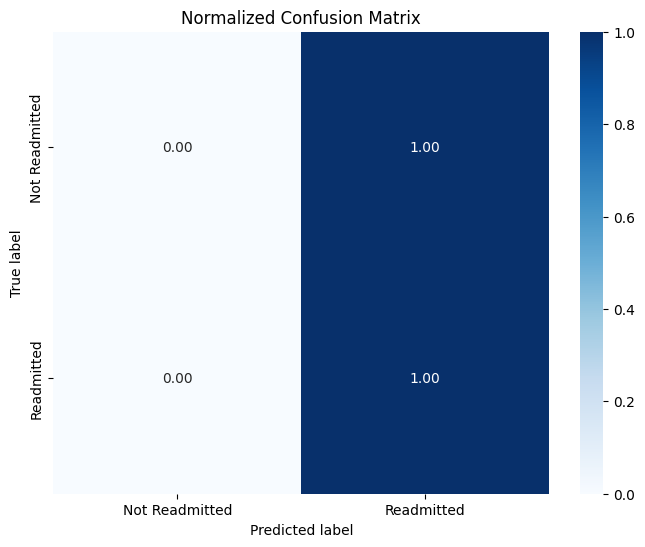

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
                precision    recall  f1-score   support

Not Readmitted       0.00      0.00      0.00      9635
    Readmitted       0.06      1.00      0.11       588

      accuracy                           0.06     10223
     macro avg       0.03      0.50      0.05     10223
  weighted avg       0.00      0.06      0.01     10223


Metrics Explanation:
- Precision: Of the patients we predicted would be readmitted, what percentage actually were
- Recall: Of the patients who were actually readmitted, what percentage did we identify
- F1-score: Harmonic mean of precision and recall
- Support: Number of occurrences of each class in the validation set


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Saved new best model with validation accuracy: 0.0575


In [ ]:
train_model(model, train_loader, val_loader, device)

Now trying Oversampling

In [ ]:
df_filtered = df[['SUBJECT_ID', 'HADM_ID', 'TEXT', 'OUTPUT_LABEL']]
X = df_filtered['TEXT']
y = df_filtered['OUTPUT_LABEL']

df_filtered['OUTPUT_LABEL'].value_counts()

OUTPUT_LABEL
0    48109
1     3004
Name: count, dtype: int64

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_filtered['TEXT'], df_filtered['OUTPUT_LABEL'], test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.tolist()
X_val = X_val.tolist()
y_train = y_train.tolist()
y_val = y_val.tolist()

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)

In [ ]:
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [ ]:
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(-1, 1), y_train)

ValueError: dtype='numeric' is not compatible with arrays of bytes/strings.Convert your data to numeric values explicitly instead.